<a href="https://colab.research.google.com/github/Siliconvalley4uYouthProjects/SpringBoard-Swatcloud/blob/main/Industry_Prediction_NLP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import regex as re
import nltk
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('swe_marketing_jobs.csv',header=None,names=['Industry','Company','Job Title','Job Description'],skiprows=1)

# Adding all job descriptions
jd = []
for jobs in df['Job Description'].astype(str):
  jd.append(jobs)

In [3]:
df.head()

,Industry,Company,Job Title,Job Description
0,Software Engineering,Amazon,Senior Software Development Engineer,4 year professional software development expe...
1,Software Engineering,Amazon,Software Development Engineer - Payments,programming experience least one modern langu...
2,Software Engineering,Amazon,Software Development Engineer - Fintech,bachelor degree computer science related field...
3,Software Engineering,Amazon,Software Development Engineer,1 year experience contributing system design a...
4,Software Engineering,Amazon,"Embedded Software Development Engineer, Satell...",1 year experience contributing system design a...


In [4]:
#Our job titles will serve as 'labels'
labels = []
for titles in df['Industry']:
  labels.append(titles)

In [5]:
#Split our data into training, validation, and testing sets
from sklearn.model_selection import train_test_split
train_jd,rem_jd,train_labels,rem_labels = train_test_split(jd,labels,train_size=0.8)
val_jd,test_jd,val_labels,test_labels = train_test_split(rem_jd,rem_labels,train_size=0.5)

In [6]:
#Hyperparameters
vocab_size = 10000
embedding_dim = 32
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

#Tokenize our job descriptions
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(jd)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(train_jd)
val_sequences = tokenizer.texts_to_sequences(val_jd)
test_sequences = tokenizer.texts_to_sequences(test_jd)
train_padded = pad_sequences(train_sequences,padding=padding_type, maxlen=max_length)
val_padded = pad_sequences(val_sequences,padding=padding_type, maxlen=max_length)
test_padded = pad_sequences(test_sequences,padding=padding_type, maxlen=max_length)

print(word_index)

{'<OOV>': 1, 'experience': 2, 'year': 3, 'degree': 4, 'related': 5, 'skill': 6, 'software': 7, 'team': 8, 'engineering': 9, 'management': 10, 'business': 11, 'data': 12, 'ability': 13, 'product': 14, 'technical': 15, 'work': 16, 'computer': 17, 'system': 18, 'development': 19, 'science': 20, 'technology': 21, 'design': 22, 'working': 23, 'bachelor': 24, 'customer': 25, 'equivalent': 26, 'field': 27, 'knowledge': 28, 'strong': 29, 'communication': 30, 'project': 31, 'cisco': 32, 'environment': 33, 'security': 34, 'including': 35, 'master': 36, 'application': 37, 'service': 38, 'andor': 39, 'language': 40, 'one': 41, 'tool': 42, 'network': 43, 'understanding': 44, 'using': 45, 'solution': 46, 'building': 47, 'complex': 48, 'cloud': 49, 'process': 50, 'programming': 51, 'c': 52, 'new': 53, 'problem': 54, 'written': 55, 'sale': 56, 'python': 57, 'role': 58, 'engineer': 59, 'area': 60, 'architecture': 61, 'required': 62, 'developing': 63, 'marketing': 64, '2': 65, 'analysis': 66, 'learning'

In [7]:
classes = set(labels)
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((v,k) for k, v in class_to_index.items())
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
train_labels = names_to_ids(train_labels)
val_labels = names_to_ids(val_labels)
test_labels = names_to_ids(test_labels)

In [8]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 32)            320000    
                                                                 
 bidirectional (Bidirectiona  (None, 16, 128)          49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 7)                 903       
                                                                 
Total params: 469,383
Trainable params: 469,383
Non-trainable params: 0
_________________________________________________________________


In [9]:
classes

{'Business & Operations',
 'Data Analysis',
 'Marketing',
 'Other Business Related',
 'Product Management',
 'Software Engineering',
 'Technology (Non-SWE)'}

In [10]:
num_epochs=20
history = model.fit(train_padded,train_labels,epochs=num_epochs,validation_data=(val_padded,val_labels),verbose=2)

Epoch 1/20
189/189 - 32s - loss: 1.3777 - accuracy: 0.5095 - val_loss: 1.0532 - val_accuracy: 0.6379 - 32s/epoch - 167ms/step
Epoch 2/20
189/189 - 32s - loss: 0.9043 - accuracy: 0.6797 - val_loss: 0.9391 - val_accuracy: 0.6751 - 32s/epoch - 170ms/step
Epoch 3/20
189/189 - 30s - loss: 0.6793 - accuracy: 0.7673 - val_loss: 0.9141 - val_accuracy: 0.7135 - 30s/epoch - 161ms/step
Epoch 4/20
189/189 - 30s - loss: 0.5363 - accuracy: 0.8219 - val_loss: 0.8902 - val_accuracy: 0.7268 - 30s/epoch - 161ms/step
Epoch 5/20
189/189 - 30s - loss: 0.4338 - accuracy: 0.8580 - val_loss: 0.9187 - val_accuracy: 0.7387 - 30s/epoch - 161ms/step
Epoch 6/20
189/189 - 30s - loss: 0.3630 - accuracy: 0.8814 - val_loss: 0.9180 - val_accuracy: 0.7334 - 30s/epoch - 161ms/step
Epoch 7/20
189/189 - 30s - loss: 0.3121 - accuracy: 0.8925 - val_loss: 1.0041 - val_accuracy: 0.7440 - 30s/epoch - 161ms/step
Epoch 8/20
189/189 - 30s - loss: 0.2921 - accuracy: 0.9005 - val_loss: 0.9512 - val_accuracy: 0.7427 - 30s/epoch - 161

In [11]:
model.evaluate(test_padded,test_labels)

24/24 [==============================] - 2s 76ms/step - loss: 1.3690 - accuracy: 0.7387


[1.3689624071121216, 0.738726794719696]

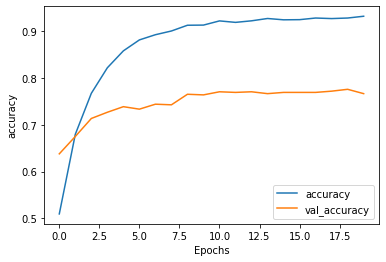

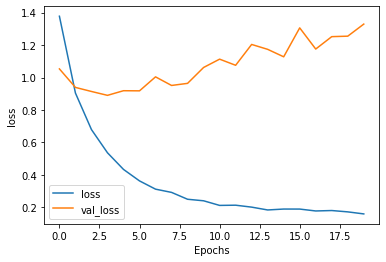

In [12]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [13]:
#Let's see if the model performs better when we reduce the industry labels to just two (either "Technology" or "Business")
df2 = pd.read_csv('swe_marketing_jobs.csv',header=None,names=['Industry','Company','Job Title','Job Description'],skiprows=1)
for i in range(len(df2['Industry'])):
  if df2['Industry'][i] in ['Software Engineering','Technology (Non-SWE)','Product Management','Data Analysis']:
    df2['Industry'][i] = 'Technology'
  elif df2['Industry'][i] in ['Business & Operations','Marketing','Other Business Related']:
    df2['Industry'][i] = 'Business'
df2['Industry'].value_counts()
df2

,Industry,Company,Job Title,Job Description
0,Technology,Amazon,Senior Software Development Engineer,4 year professional software development expe...
1,Technology,Amazon,Software Development Engineer - Payments,programming experience least one modern langu...
2,Technology,Amazon,Software Development Engineer - Fintech,bachelor degree computer science related field...
3,Technology,Amazon,Software Development Engineer,1 year experience contributing system design a...
4,Technology,Amazon,"Embedded Software Development Engineer, Satell...",1 year experience contributing system design a...
...,...,...,...,...
7532,Business,Cisco,"Lab Specialist, MS",interested please apply httpsgrnhse406548db1us...
7533,Business,Cisco,Security Architect,cisco security visibility incident command tea...
7534,Technology,Cisco,Software Engineer I (Co-Op) United States,including limited upcoming graduate technical ...
7535,Technology,Cisco,Software Engineer II (Intern) United States,including limited upcoming graduate technical ...


In [14]:
labels2 = []
for titles in df2['Industry']:
  labels2.append(titles)

In [15]:
#Split our data into training, validation, and testing sets
train_jd2,rem_jd2,train_labels2,rem_labels2 = train_test_split(jd,labels2,train_size=0.8)
val_jd2,test_jd2,val_labels2,test_labels2 = train_test_split(rem_jd2,rem_labels2,train_size=0.5)

In [16]:
#Tokenize our job descriptions again
train_sequences2 = tokenizer.texts_to_sequences(train_jd2)
val_sequences2 = tokenizer.texts_to_sequences(val_jd2)
test_sequences2 = tokenizer.texts_to_sequences(test_jd2)
train_padded2 = pad_sequences(train_sequences2,padding=padding_type, maxlen=max_length)
val_padded2 = pad_sequences(val_sequences2,padding=padding_type, maxlen=max_length)
test_padded2 = pad_sequences(test_sequences2,padding=padding_type, maxlen=max_length)

In [17]:
classes2 = set(labels2)
class_to_index2 = dict((c,i) for i, c in enumerate(classes2))
index_to_class2 = dict((v,k) for k, v in class_to_index2.items())
names_to_ids2 = lambda labels2: np.array([class_to_index2.get(x) for x in labels2])
train_labels2 = names_to_ids2(train_labels2)
val_labels2 = names_to_ids2(val_labels2)
test_labels2 = names_to_ids2(test_labels2)

In [18]:
model2 = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
tf.keras.layers.Dense(7, activation='softmax')
])

model2.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

num_epochs=20
history2 = model2.fit(train_padded2,train_labels2,epochs=num_epochs,validation_data=(val_padded2,val_labels2),verbose=2)

Epoch 1/20
189/189 - 31s - loss: 0.5479 - accuracy: 0.7706 - val_loss: 0.3959 - val_accuracy: 0.8462 - 31s/epoch - 163ms/step
Epoch 2/20
189/189 - 31s - loss: 0.2494 - accuracy: 0.9045 - val_loss: 0.3444 - val_accuracy: 0.8674 - 31s/epoch - 161ms/step
Epoch 3/20
189/189 - 31s - loss: 0.1732 - accuracy: 0.9393 - val_loss: 0.3378 - val_accuracy: 0.8820 - 31s/epoch - 162ms/step
Epoch 4/20
189/189 - 31s - loss: 0.1385 - accuracy: 0.9478 - val_loss: 0.3443 - val_accuracy: 0.8952 - 31s/epoch - 162ms/step
Epoch 5/20
189/189 - 31s - loss: 0.1196 - accuracy: 0.9564 - val_loss: 0.3361 - val_accuracy: 0.8886 - 31s/epoch - 162ms/step
Epoch 6/20
189/189 - 31s - loss: 0.1073 - accuracy: 0.9595 - val_loss: 0.3283 - val_accuracy: 0.8859 - 31s/epoch - 163ms/step
Epoch 7/20
189/189 - 31s - loss: 0.0982 - accuracy: 0.9635 - val_loss: 0.3466 - val_accuracy: 0.8912 - 31s/epoch - 162ms/step
Epoch 8/20
189/189 - 31s - loss: 0.0864 - accuracy: 0.9623 - val_loss: 0.3688 - val_accuracy: 0.9045 - 31s/epoch - 162

In [32]:
model2.evaluate(test_padded2,test_labels2)

24/24 [==============================] - 5s 182ms/step - loss: 0.5145 - accuracy: 0.8833


[0.5144889950752258, 0.883289098739624]

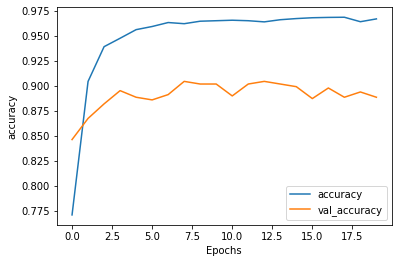

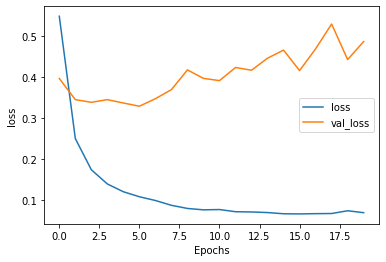

In [20]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

Our model seems to perform better with the extra labels instead of just having two.

In [21]:
conv_model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
tf.keras.layers.Conv1D(128,5,activation='relu'),
tf.keras.layers.GlobalMaxPooling1D(),
tf.keras.layers.Dense(7, activation='softmax')
])

conv_model.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

conv_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 32)            320000    
                                                                 
 conv1d (Conv1D)             (None, 12, 128)           20608     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 341,511
Trainable params: 341,511
Non-trainable params: 0
_________________________________________________________________


In [22]:
conv_history = conv_model.fit(train_padded,train_labels,epochs=num_epochs,validation_data=(val_padded,val_labels),verbose=2)

Epoch 1/20
189/189 - 4s - loss: 1.5044 - accuracy: 0.4725 - val_loss: 1.1582 - val_accuracy: 0.6008 - 4s/epoch - 24ms/step
Epoch 2/20
189/189 - 4s - loss: 0.9883 - accuracy: 0.6565 - val_loss: 0.9220 - val_accuracy: 0.6830 - 4s/epoch - 22ms/step
Epoch 3/20
189/189 - 4s - loss: 0.6936 - accuracy: 0.7736 - val_loss: 0.8432 - val_accuracy: 0.7255 - 4s/epoch - 22ms/step
Epoch 4/20
189/189 - 4s - loss: 0.4906 - accuracy: 0.8504 - val_loss: 0.8329 - val_accuracy: 0.7440 - 4s/epoch - 22ms/step
Epoch 5/20
189/189 - 4s - loss: 0.3576 - accuracy: 0.8915 - val_loss: 0.8313 - val_accuracy: 0.7706 - 4s/epoch - 22ms/step
Epoch 6/20
189/189 - 4s - loss: 0.2798 - accuracy: 0.9124 - val_loss: 0.8689 - val_accuracy: 0.7639 - 4s/epoch - 22ms/step
Epoch 7/20
189/189 - 4s - loss: 0.2390 - accuracy: 0.9202 - val_loss: 0.9103 - val_accuracy: 0.7719 - 4s/epoch - 22ms/step
Epoch 8/20
189/189 - 4s - loss: 0.2142 - accuracy: 0.9230 - val_loss: 0.9203 - val_accuracy: 0.7679 - 4s/epoch - 23ms/step
Epoch 9/20
189/1

24/24 [==============================] - 0s 9ms/step - loss: 0.9499 - accuracy: 0.7692


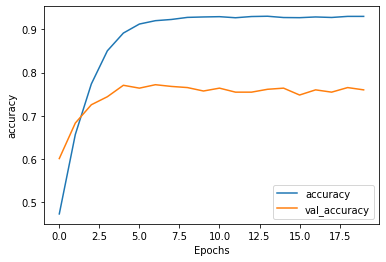

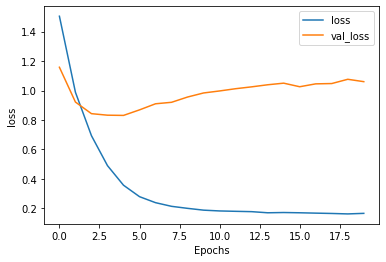

In [23]:
conv_model.evaluate(test_padded,test_labels)
plot_graphs(conv_history, "accuracy")
plot_graphs(conv_history, "loss")

**Testing Demo: LinkedIn Profiles**

In [24]:
def classify(input,model,tokenizer):
  qualifications = tokenizer.texts_to_sequences([input])
  qualifications = pad_sequences(qualifications,padding=padding_type,maxlen=max_length)
  predictions = model.predict(qualifications)
  classify_df = pd.DataFrame(columns=['Industry','% Match'])
  classify_df['Industry'] = list(classes)
  for i in range(len(predictions[0])):
    classify_df['% Match'][i] = predictions[0][i]*100
  classify_df.set_index('Industry',inplace=True)
  print(classify_df.sort_values(by='% Match',ascending=False))

Candidate #1: Software Engineer @ Microsoft with prior experience as a team lead for engineers working in sales analytics

In [25]:
classify('Azure Kubernetes Service (AKS) team - Built a web server in Golang and wrote unit tests. Designed and deployed it with a microservices architecture, leveraging Kubernetes communication patterns. - Containerized the web server using a multistage Docker build process and packaged it into a Helm Chart. Set up a CI/CD pipeline to automatically test and deploy application to an AKS cluster. - Created a logging and metrics infrastructure, using Azure Log Analytics, Prometheus, and Grafana to monitor application behavior and system health. Led a team of engineers and product managers to shape the evolution of Dropbox’s central sales analytics tool. While leading the team, we: - Increased adoption of the platform by 2.4x in 2020. - Built a PowerPoint generation engine to deliver customized, data-driven sales materials at scale, enhancing productivity of the sales organization by ~500 hours per quarter. - Advised global sales teams on strategic customers through bespoke analytics. Designed a scalable model that resulted in a 10% increase in ARR influenced each quarter.',conv_model,tokenizer)

1/1 [==============================] - 0s 25ms/step
                          % Match
Industry                         
Software Engineering    94.351727
Technology (Non-SWE)     3.312557
Other Business Related   2.273427
Data Analysis            0.062204
Product Management       0.000048
Marketing                0.000042
Business & Operations    0.000012


Candidate #2: Software Engineer @ Amazon with academic background in computer science and data science

In [26]:
classify('-Worked on the backend team to develop the Edtera web application, a learning engagement platform, using the Java Spring MVC Framework -Implemented data access layer using Spring Data JPA to allow various CRUD services to Edtera’s PostgreSQL database -Developed a performance tracker using Spring RestTemplate to retrieve students’ enrollment and grade data from third party learning management systems and configured RestTemplate Interceptor to reduce redundancy in the code -Built RESTful services to publish data by creating Rest Controllers, such as grades, course, enrollment information, etc. -Developed a high-performance laser health monitoring program with Python, which was highly recognized by the course instructor and project sponsor and selected for exhibition at the Department Senior Design Day -Implemented Random Forest Regression using Scikit-Learn library to predict laser survival rate, achieving MAPE of 12% -Created an interactive data visualization web application with Python Dash framework for explorative analysis -Designed a feature engineering procedure to sum the time series data and convert it to a supervised-learning problem',conv_model,tokenizer)

1/1 [==============================] - 0s 17ms/step
                          % Match
Industry                         
Software Engineering    67.988569
Technology (Non-SWE)    21.126328
Data Analysis            7.787841
Other Business Related   3.058021
Business & Operations    0.020837
Marketing                0.014249
Product Management        0.00415


Candidate #3: Senior Marketing Analytics Manager @ Rippling with extensive work history as a marketing data analyst

In [30]:
classify('1. Create measurement framework across different funnel stages (TOF, MOF, and BOF) and marketing channels & campaigns: 1) identify KPIs (primary & secondary) and 2) define leading indicators 2. Build reporting foundation and consistently report on 1) actuals against goals by segment, marketing channel, campaign, and product and 2) trend on performance across acquisition and cross-sell motions. Identify gaps on data tracking, data connection, and reporting infrastructure and implement solutions. 3. Develop a framework to measure channel and campaign effectiveness and efficiency through attribution (FT, LT, & MT) and incrementality (MMM & geo-based experiments). Marketing channels include Paid Social (LinkedIn & Facebook & YouTube), Paid & Organic Search, Review Sites, and OOH 4. Hire and grow a Marketing Analytics team, mentor and coach analyst(s) to deliver high-quality work 1. Acquisition Marketing Channel and Campaign Analysis - Measure acquisition marketing campaign performance through Geo experiments, time series models, and platform lift studies; Channels include brand media, such as TV, OTT, Streaming Audio, & Podcast, and OA media, such as Display, OLV, Paid Social, Paid Search, and Affiliates - Design and measure channel incrementality tests (PPC Brand & OTT/CTV) and other tests, such as bid algorithm test and landing page test, across different product segments - Provide on-going channel and campaign performance analysis via prediction models, pre-post analysis, and A/B tests; Create channel performance dashboard (Holistic Search) to inform efficiency - Provide insights and recommendations on channel and campaign performance to marketing stakeholders and the leadership team based on the test and analysis results 2. Product Performance Analysis - Analytics lead on weekly marketing acquisition performance across all channels (Brand and OA) for Quickbooks Online product. - Work with finance, marketing, sales, and other analytics teams to identify performance root causes. - Define full-funnel metrics to measure marketing acquisition performance, such as brand metrics, QBO brand and industry search demand, traffic and conversion rate, sales, and CPA. 1. CRM/Database Marketing Management and Strategies - CRM database and email & direct mail channels owner and work with sales team for outbound call campaigns. Develop, optimize, monitor, and execute database marketing campaigns including re-marketing, cross-sell, acquisition, and win-back. - Analyze CRM customer & campaign data on different segments to improve overall DBM campaign performance. Auto re-marketing campaign sales contribute 13.5% of total company sales in 2016. - Provide on-going analysis on CRM data to define targeting and segmentation strategies for marketing acquisition campaigns. Design A/B and multivariate tests and define KPIs to measure test success. - Oversee design, development, and maintenance of a CRM database. Work with a cross-functional team (product, analytics, development, and BI) to define database and data integration requirements. - Collaborate with data science, sales, BI, and IT teams to build and implement models used for segmentation and targeting strategies to increase customer lifetime value and campaign ROI. - Provide insights and recommendations to the senior management team to influence decision making. 2. Marketing Analytics - Lead all aspects of Marketing Analytics, including campaign analysis, reporting, and predictive modeling. Marketing channels include email, SEM, affiliates, paid social, and sponsorship. - Provide on-going analysis on CRM data to inform targeting and segmentation strategies for marketing acquisition campaigns. Design tests and define KPIs to measure campaign and test success. - Analyze cost, engagement, and sales data to propose U.S. budget re-allocation recommendations across marketing channels to increase conversion, ROI, and improve customer mix. - Set KPIs and lead efforts to provide and consolidate analysis and reporting for website testing. - Provide insights and recommendations to the senior management team to influence decision making.',conv_model,tokenizer)

1/1 [==============================] - 0s 28ms/step
                          % Match
Industry                         
Technology (Non-SWE)    63.709623
Marketing               11.712246
Other Business Related  10.993959
Data Analysis             6.59488
Software Engineering     4.643743
Product Management       2.150447
Business & Operations    0.195097


Candidate #4: Product Manager @ Meta with prior experience as a consultant at Deloitte Digital

In [31]:
classify('Product Manager for Strategic Transformation Tool: Led a nine-person product team to design, build, and launch StrategyAccelerator® - a single, customizable digital platform to help companies drive ideation to implementation across their business strategy life cycle, resulting in 17 client wins and $xxM revenue in direct asset fees and services for Deloitte Product and Monetization Strategy for a Pharmaceutical Company: Managed a five-person team to develop and prioritize 42 use cases and monetization opportunities of facial and retinal scans towards disruptive applications of AI and ML for disease detection and treatment targeting direct-to-consumer opportunities Marketing Strategy, Operations, and Annual Planning for $9B Cloud Technology Company: Led a five-person team working directly with the CMO and SVPs to spearhead annual strategic planning, and successfully secured ~$600M, the highest % of investment allocation for the marketing organization thus far from the C-suite eCommerce Partnership Strategy for $600B Global Social Media Company: Led leadership strategy workshops engaging cross-functionally with sales, product development, and privacy compliance to identify target large and mid-size retailers for ecommerce offering expansion, and develop a GTM plan for ~60M potential buyers Customer Experience and Journey Mapping for Fortune 500 Financial Services Company: Designed product roadmap to improve customer satisfaction and retention; directed ethnographic research leading to insights on key customer behaviors via quantitative surveys and interviews to understand customer journeys and shape new service offerings',conv_model,tokenizer)

1/1 [==============================] - 0s 24ms/step
                          % Match
Industry                         
Other Business Related  47.823909
Technology (Non-SWE)    46.790057
Business & Operations    2.368764
Data Analysis            1.930019
Software Engineering     1.080558
Marketing                0.006228
Product Management       0.000472


Candidate #5: Investment Banker @ Brookwood Associates. No background in tech - purely a finance person.

In [29]:
classify('- Represented CAIRE on its second U.S. acquisition of MGC Diagnostics, a manufacturer of cardiorespiratory diagnostics systems - Represented provider of transactional communications solutions on its sale to Doxim, a portfolio company of GI Partners - Represented CAIRE, a subsidiary of NGK Spark Plugs, on its acquisition of an e-commerce seller of portable oxygen concentrators and other respiratory products - Represented manufacturer of advanced composite materials on its recapitalization - Represented provider of water and wastewater infrastructure services on its sale to Sciens Water - Represented provider of center-based, home-based, and school-based behavioral healthcare services for individuals with autism spectrum disorders on its sale to LEARN Behavioral, a portfolio company of Gryphon Investors - Represented provider of urgent care services on its merger with CRH Healthcare - Represented distributor of industrial air compressors and compressed air automation systems on its recapitalization - Represented manufacturer of domestic and imported hardwood lumber on the divestiture of its distribution business to the Rugby Architectural Building Products division of Hardwoods Distribution Inc. (TSX:HDI) - Represented vertically integrated manufacturer of technical and performance fabrics on its sale to Milliken & Company - Represented manufacturer of wakeboard towers and accessories and custom-patterned boat covers on its sale to a financial sponsor - Represented specialty mattress retailer with 130+ locations in the Midwest and Southeast on its sale to Mattress Firm',conv_model,tokenizer)

1/1 [==============================] - 0s 16ms/step
                          % Match
Industry                         
Technology (Non-SWE)    57.294023
Other Business Related  38.720044
Business & Operations    3.064166
Data Analysis            0.436559
Software Engineering      0.34085
Marketing                0.103223
Product Management       0.041137
